# TB Drug Susceptibility Mutations

In [1]:
# Import Statements
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
cwd = Path.cwd()

## Data Preprocessing
Since we are using stratified kfold, a validation split is not necesssary.

### Load data

In [2]:
df = pd.read_csv('filtered.csv')

X = df[['original', 'new']]
X.columns = ['WT', 'Mutant']
effect_score = df['effect score']
effect = df['effect']
y = df['drug']

In [3]:
aa_prop = X.replace({'Gly': 'non-polar', 'Ala': 'non-polar', 'Val': 'non-polar', 'Cys': 'non-polar', 'Pro': 'non-polar', 
                      'Leu': 'non-polar', 'Ile': 'non-polar', 'Met': 'non-polar', 'Trp': 'non-polar', 'Phe': 'non-polar', 
                      'Ser': 'polar', 'Thr': 'polar', 'Tyr': 'polar', 'Asn': 'polar', 'Gln': 'polar', 
                      'Lys': 'pos', 'Arg': 'pos', 'His': 'pos', 'Asp': 'neg', 'Glu': 'neg'})
aa_prop.columns = ['WT Property', 'Mutant Property']

In [4]:
# Hydrophobic = 1, Hydrophilic = -1
hydrophobic = X.replace({'Gly': 1, 'Ala': 1, 'Val': 1, 'Cys': 1, 'Pro': 1, 
                          'Leu': 1, 'Ile': 1, 'Met': 1, 'Trp': 1, 'Phe': 1, 
                          'Ser': -1, 'Thr': -1, 'Tyr': -1, 'Asn': -1, 'Gln': -1, 
                          'Lys': -1, 'Arg': -1, 'His': -1, 'Asp': -1, 'Glu': -1})

hydrophobic.columns = ['WT Hydrophobicity', 'Mutant Hydrophobicity']

In [5]:
def get_hydrophobic(x):
    if x[0] == -1 and x[1] == 1:
        return 1
    if x[0] == 1 and x[1] == -1:
        return -1
    else:
        return 0
    
hydrophobic_change = hydrophobic.apply(get_hydrophobic, axis=1)
hydrophobic_change.name = 'Hydrophobicity Change'

In [6]:
def get_charge(x):
    if x[0] == 'pos' and (x[1] == 'non-polar' or x[1] == 'polar'):
        return -1
    elif x[0] == 'pos' and x[1] == 'neg':
        return -2
    elif x[0] == 'neg' and (x[1] == 'non-polar' or x[1] == 'polar'):
        return 1
    elif x[0] == 'neg' and x[1] == 'pos':
        return 2
    elif (x[0] == 'non-polar' or x[0] == 'polar') and x[1] == 'pos':
        return 1
    elif (x[0] == 'non-polar' or x[0] == 'polar') and x[1] == 'neg':
        return -1
    
    else:
        return 0
    
charge = aa_prop.apply(get_charge, axis=1)
charge.name = 'Charge Change'

In [7]:
mw = X.replace({'Gly': 75, 'Ala': 89, 'Val': 117, 'Cys': 121, 'Pro': 115, 
                      'Leu': 131, 'Ile': 131, 'Met': 149, 'Trp': 204, 'Phe': 165, 
                      'Ser': 105, 'Thr': 119, 'Tyr': 181, 'Asn': 132, 'Gln': 146, 
                      'Lys': 146, 'Arg': 174, 'His': 155, 'Asp': 133, 'Glu': 147})
mw.columns = ['WT MW', 'Mutant MW']

mw_change = mw['Mutant MW'] - mw['WT MW']
mw_change.name = 'MW Change'

### Combine Features

In [8]:
X = pd.concat([X, 
               aa_prop, 
               hydrophobic, 
               hydrophobic_change, 
               charge, 
               effect_score, 
               effect, 
               mw, 
               mw_change], axis=1)
X = X.drop(columns=['effect score', 'effect'], axis=1)
display(X)

,WT,Mutant,WT Property,Mutant Property,WT Hydrophobicity,Mutant Hydrophobicity,Hydrophobicity Change,Charge Change,WT MW,Mutant MW,MW Change
0,Val,Ala,non-polar,non-polar,1,1,0,0,117,89,-28
1,Ser,Arg,polar,pos,-1,-1,0,1,105,174,69
2,Ser,Ile,polar,non-polar,-1,1,1,0,105,131,26
3,Asp,Gly,neg,non-polar,-1,1,1,1,133,75,-58
4,Met,Leu,non-polar,non-polar,1,1,0,0,149,131,-18
...,...,...,...,...,...,...,...,...,...,...,...
86,Met,Thr,non-polar,polar,1,-1,-1,0,149,119,-30
87,Leu,Pro,non-polar,non-polar,1,1,0,0,131,115,-16
88,Tyr,Asp,polar,neg,-1,-1,0,-1,181,133,-48
89,Tyr,His,polar,pos,-1,-1,0,1,181,155,-26


In [9]:
# to_save = pd.concat([y, X], axis=1)
# to_save.to_csv(cwd / 'parsed_data.csv', sep=',', index=False, header=True)

### Encoding

In [10]:
from sklearn.preprocessing import OrdinalEncoder

aa_encoder = OrdinalEncoder()
prop_encoder = OrdinalEncoder()

X[['WT', 'Mutant']] = aa_encoder.fit_transform(X[['WT', 'Mutant']]) + 1
X[['WT Property', 'Mutant Property']] = prop_encoder.fit_transform(X[['WT Property', 'Mutant Property']]) + 1


y = y.replace({'Resistant': 1, 'Susceptible': 0})

In [11]:
display(X)

,WT,Mutant,WT Property,Mutant Property,WT Hydrophobicity,Mutant Hydrophobicity,Hydrophobicity Change,Charge Change,WT MW,Mutant MW,MW Change
0,17.0,1.0,2.0,2.0,1,1,0,0,117,89,-28
1,13.0,2.0,3.0,4.0,-1,-1,0,1,105,174,69
2,13.0,10.0,3.0,2.0,-1,1,1,0,105,131,26
3,4.0,8.0,1.0,2.0,-1,1,1,1,133,75,-58
4,11.0,11.0,2.0,2.0,1,1,0,0,149,131,-18
...,...,...,...,...,...,...,...,...,...,...,...
86,11.0,17.0,2.0,3.0,1,-1,-1,0,149,119,-30
87,10.0,15.0,2.0,2.0,1,1,0,0,131,115,-16
88,16.0,4.0,3.0,1.0,-1,-1,0,-1,181,133,-48
89,16.0,9.0,3.0,4.0,-1,-1,0,1,181,155,-26


In [12]:
# to_save = pd.concat([y, X], axis=1)
# to_save.to_csv(cwd / 'parsed_data.csv', sep=',', index=False, header=True)

### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

# Test data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    random_state=66,
                                                    test_size=0.5,
                                                    stratify=y)

Printing the number of genus taxa

Here I print the number of examples for each split of data.

In [14]:
def get_metadata(y, df):
    pos = len(y[y == 1])
    neg = len(y[y == 0])
    row = pd.DataFrame({'Resistant': [pos], 'Susceptible': [neg]})
    df = df.append(row)
    return df


metadata = pd.DataFrame(columns=['Resistant', 'Susceptible'])
metadata = get_metadata(y_train, metadata)
metadata = get_metadata(y_test, metadata)
metadata.index = ['train', 'test']
display(metadata)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,Resistant,Susceptible
train,29,16
test,30,16


## Optimising model hyperparameters
We use gridsearch to do hyperparameter optimisation (n_estimators, max_depth).
n_estimators: Number of tree stumps
max_depth: max depth of nodes in tree stumps

In [15]:
def optimise(X, y):
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(50, 200, 5)
    max_depth = range(1, 3, 1)
    gamma = list(np.arange(1, 6, 1) / 10)
    colsample_bytree = [6/11, 7/11, 8/11, 9/11, 10/11, 11/11]
    reg_lambda = [1, 1.5]
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      gamma = gamma,
                      colsample_bytree=colsample_bytree,
                      reg_lambda = reg_lambda,
                      scale_pos_weight = [ratio])
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=66)
    grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(X, y)
    # summarize results
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Print parameters and scores
#     for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))

    return(grid_result.best_params_)

In [16]:
# params = optimise(X_train, y_train)
params = {'colsample_bytree': 0.7272727272727273, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 105, 'reg_lambda': 1.5, 'scale_pos_weight': 0.5423728813559322}

## Fit optimised models

In [17]:
# Fit optimised model on all training data
drug_model = XGBClassifier(**params)
drug_model.fit(X=X_train, y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7272727272727273,
              gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=105, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.5, scale_pos_weight=0.5423728813559322,
              seed=None, silent=None, subsample=1, verbosity=1)

## Evaluate model

In [18]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, average_precision_score


def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]

    precision, recall, fscore, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average='binary')
    auc = average_precision_score(y_true=y_test, y_score=y_score, average='weighted')
    metric_df = pd.DataFrame({'Precision': [precision],
                              'Recall': [recall],
                              'F1': [fscore],
                              'AUPRC': [auc]})
    return metric_df


# Evaluate on test data
xgb_train = evaluate(drug_model, X_train, y_train)
xgb_test = evaluate(drug_model, X_test, y_test)
metrics = pd.concat([xgb_train, xgb_test], axis=0)
metrics.index = ['Train', 'Test']
display(metrics.round(3))

,Precision,Recall,F1,AUPRC
Train,0.929,0.897,0.912,0.976
Test,0.800,0.800,0.800,0.860


## Permutation test

In [19]:
from sklearn.utils import resample
n_iter = 10000
perm_df = pd.DataFrame({'Precision': [0],
                        'Recall': [0],
                        'F1': [0],
                        'AUPRC': [0]})
# Test data
np.random.seed(66)
for _ in range(n_iter):
    y_perm = resample(y, replace=False)
    
    X_perm_train, X_perm_test, y_perm_train, y_perm_test = train_test_split(X, y_perm,
                                                                  shuffle=True,
                                                                  random_state=66,
                                                                  test_size=0.5,
                                                                  stratify=y_perm)

    perm_model = XGBClassifier(**params)
    perm_model.fit(X=X_perm_train, y=y_perm_train)
    perm_metric = evaluate(perm_model, X_perm_test, y_perm_test)
    perm_df = pd.concat([perm_df, perm_metric], axis=0)

perm_df = perm_df.iloc[1:, :]

In [20]:
auc_p = sum(perm_df['AUPRC'] >= xgb_test['AUPRC'][0]) / n_iter

print(auc_p)

0.0022


## Interpreting model using SHAP values

### Feature importance
This is a plot of mean absolute SHAP values per feature

In [21]:
import shap
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(drug_model, feature_pertubation='interventional', model_output='probability', data=X_test)
shap_drug = explainer.shap_values(X_test)

### Plot of SHAP values per Feature

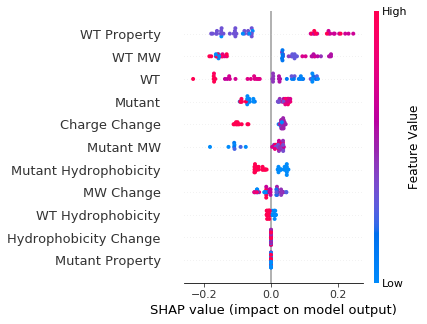

In [22]:
shap.summary_plot(shap_drug, X_test, show=False, plot_size=(4, 5), color_bar_label='Feature Value')
# fig, ax = plt.gcf(), plt.gca()
# ax.set_xlabel('SHAP Value')
plt.savefig(cwd / 'shap_summary_plot.png', dpi=1200, format='png', bbox_inches='tight')

## Predictions

In [31]:
to_predict = pd.read_csv(cwd / 'to_predict.csv')
display(to_predict)

to_predict = to_predict[['original', 'new']]
to_predict.columns = ['WT', 'Mutant']

aa_prop = to_predict.replace({'Gly': 'non-polar', 'Ala': 'non-polar', 'Val': 'non-polar', 'Cys': 'non-polar', 'Pro': 'non-polar', 
                              'Leu': 'non-polar', 'Ile': 'non-polar', 'Met': 'non-polar', 'Trp': 'non-polar', 'Phe': 'non-polar', 
                              'Ser': 'polar', 'Thr': 'polar', 'Tyr': 'polar', 'Asn': 'polar', 'Gln': 'polar', 
                              'Lys': 'pos', 'Arg': 'pos', 'His': 'pos', 'Asp': 'neg', 'Glu': 'neg'})

aa_prop.columns = ['WT Property', 'Mutant Property']

hydrophobic = to_predict.replace({'Gly': 1, 'Ala': 1, 'Val': 1, 'Cys': 1, 'Pro': 1, 
                                  'Leu': 1, 'Ile': 1, 'Met': 1, 'Trp': 1, 'Phe': 1, 
                                  'Ser': -1, 'Thr': -1, 'Tyr': -1, 'Asn': -1, 'Gln': -1, 
                                  'Lys': -1, 'Arg': -1, 'His': -1, 'Asp': -1, 'Glu': -1})

hydrophobic.columns = ['WT Hydrophobicity', 'Mutant Hydrophobicity']    
hydrophobic_change = hydrophobic.apply(get_hydrophobic, axis=1)
hydrophobic_change.name = 'Hydrophobicity Change'
    
charge = aa_prop.apply(get_charge, axis=1)
charge.name = 'Charge Change'

mw = to_predict.replace({'Gly': 75, 'Ala': 89, 'Val': 117, 'Cys': 121, 'Pro': 115, 
                          'Leu': 131, 'Ile': 131, 'Met': 149, 'Trp': 204, 'Phe': 165, 
                          'Ser': 105, 'Thr': 119, 'Tyr': 181, 'Asn': 132, 'Gln': 146, 
                          'Lys': 146, 'Arg': 174, 'His': 155, 'Asp': 133, 'Glu': 147})
mw.columns = ['WT MW', 'Mutant MW']

mw_change = mw['Mutant MW'] - mw['WT MW']
mw_change.name = 'MW Change'

to_predict = pd.concat([to_predict, 
                        aa_prop, 
                        hydrophobic, 
                        hydrophobic_change, 
                        charge,
                        mw, 
                        mw_change], axis=1)

to_predict[['WT', 'Mutant']] = aa_encoder.fit_transform(to_predict[['WT', 'Mutant']]) + 1
to_predict[['WT Property', 'Mutant Property']] = prop_encoder.fit_transform(to_predict[['WT Property', 'Mutant Property']]) + 1

display(to_predict)

,original,new,drug,effect score,effect,position,ligand_binding
0,Ala,Val,INFERRED,-2.348,Neutral,36,0
1,Ala,Gly,INFERRED,-2.925,Deleterious,59,0
2,Ala,Ser,INFERRED,-1.497,Neutral,59,0
3,Leu,Arg,INFERRED,-3.111,Deleterious,154,0
4,Asn,Thr,Unknown,-0.455,Neutral,4,0
...,...,...,...,...,...,...,...
139,Thr,Ile,Unknown,-1.712,Neutral,161,0
140,Thr,Pro,Unknown,-0.832,Neutral,161,0
141,Thr,Ile,Unknown,-1.712,Neutral,161,0
142,Thr,Pro,Unknown,-0.832,Neutral,161,0


,WT,Mutant,WT Property,Mutant Property,WT Hydrophobicity,Mutant Hydrophobicity,Hydrophobicity Change,Charge Change,WT MW,Mutant MW,MW Change
0,1.0,20.0,2.0,2.0,1,1,0,0,89,117,28
1,1.0,8.0,2.0,2.0,1,1,0,0,89,75,-14
2,1.0,16.0,2.0,3.0,1,-1,-1,0,89,105,16
3,9.0,2.0,2.0,4.0,1,-1,-1,1,131,174,43
4,3.0,17.0,3.0,3.0,-1,-1,0,0,132,119,-13
...,...,...,...,...,...,...,...,...,...,...,...
139,14.0,10.0,3.0,2.0,-1,1,1,0,119,131,12
140,14.0,15.0,3.0,2.0,-1,1,1,0,119,115,-4
141,14.0,10.0,3.0,2.0,-1,1,1,0,119,131,12
142,14.0,15.0,3.0,2.0,-1,1,1,0,119,115,-4


In [45]:
predicted = drug_model.predict_proba(to_predict)

np.savetxt(cwd / 'predicted_scores.csv', predicted, delimiter=',')

In [46]:
drug_model.predict(to_predict)

array([1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [23]:
import xgboost as xgb
xgb.__version__

'0.90'

In [24]:
shap.__version__

'0.34.0'